# CR_Score Playbook 03: Visualization & Reporting

**Level:** Intermediate  
**Time:** 15-20 minutes  
**Goal:** Create beautiful visualizations and professional reports

## What You'll Learn

- Binning visualizations (WoE, IV, distributions)
- Scorecard performance plots (ROC, KS, calibration)
- Score distribution analysis
- Generate HTML reports

## Prerequisites

- Completed Playbook 01

## Step 1: Setup and Build Scorecard

In [3]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

from cr_score import ScorecardPipeline
from cr_score.viz import BinningVisualizer, ScoreVisualizer
from cr_score.reporting import HTMLReportGenerator

print("[OK] Libraries imported!")

[OK] Libraries imported!


In [4]:
# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Build scorecard
pipeline = ScorecardPipeline(max_n_bins=5, pdo=20, base_score=600)
pipeline.fit(train_df, target_col='default')
scores = pipeline.predict(test_df)
probas = pipeline.predict_proba(test_df)

print("[OK] Scorecard built!")

{"event": "================================================================================", "timestamp": "2026-01-16T13:21:45.759033Z", "level": "info"}
{"event": "Starting CR_Score Pipeline", "timestamp": "2026-01-16T13:21:45.760033Z", "level": "info"}
{"event": "================================================================================", "timestamp": "2026-01-16T13:21:45.760033Z", "level": "info"}
{"event": "\n[1/5] Auto-binning with OptimalBinning...", "timestamp": "2026-01-16T13:21:45.761034Z", "level": "info"}
{"event": "Auto-binning 15 features", "timestamp": "2026-01-16T13:21:45.761034Z", "level": "info"}
{"max_n_bins": 5, "monotonic_trend": "auto", "event": "Fitting OptimalBinning for application_id", "timestamp": "2026-01-16T13:21:45.762034Z", "level": "info"}
{"n_bins": 4, "iv": 0.1642752080448383, "event": "OptimalBinning completed", "timestamp": "2026-01-16T13:21:45.816043Z", "level": "info"}
{"event": "  application_id: IV=0.164 - INCLUDED", "timestamp": "2026-01-1

c:\Users\EDMUN\workspace\projects\21_ScoreForge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## Step 2: Binning Visualizations

{"max_n_bins": 5, "monotonic_trend": "auto", "event": "Fitting OptimalBinning for debt_to_income_ratio", "timestamp": "2026-01-16T13:33:03.978453Z", "level": "info"}
{"n_bins": 4, "iv": 0.45707935312395553, "event": "OptimalBinning completed", "timestamp": "2026-01-16T13:33:04.012647Z", "level": "info"}
Binning table columns: ['Bin', 'Count', 'Count (%)', 'Non-event', 'Event', 'Event rate', 'WoE', 'IV', 'JS']

Binning table:
                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.18)   1055   0.301429       1045     10    0.009479   
1       [0.18, 0.22)    323   0.092286        321      2    0.006192   
2       [0.22, 0.32)    839   0.239714        838      1    0.001192   
3        [0.32, inf)   1283   0.366571       1278      5    0.003897   
4            Special      0   0.000000          0      0    0.000000   
5            Missing      0   0.000000          0      0    0.000000   
Totals                 3500   1.000000       3482     18    0.00514

KeyError: 'woe'

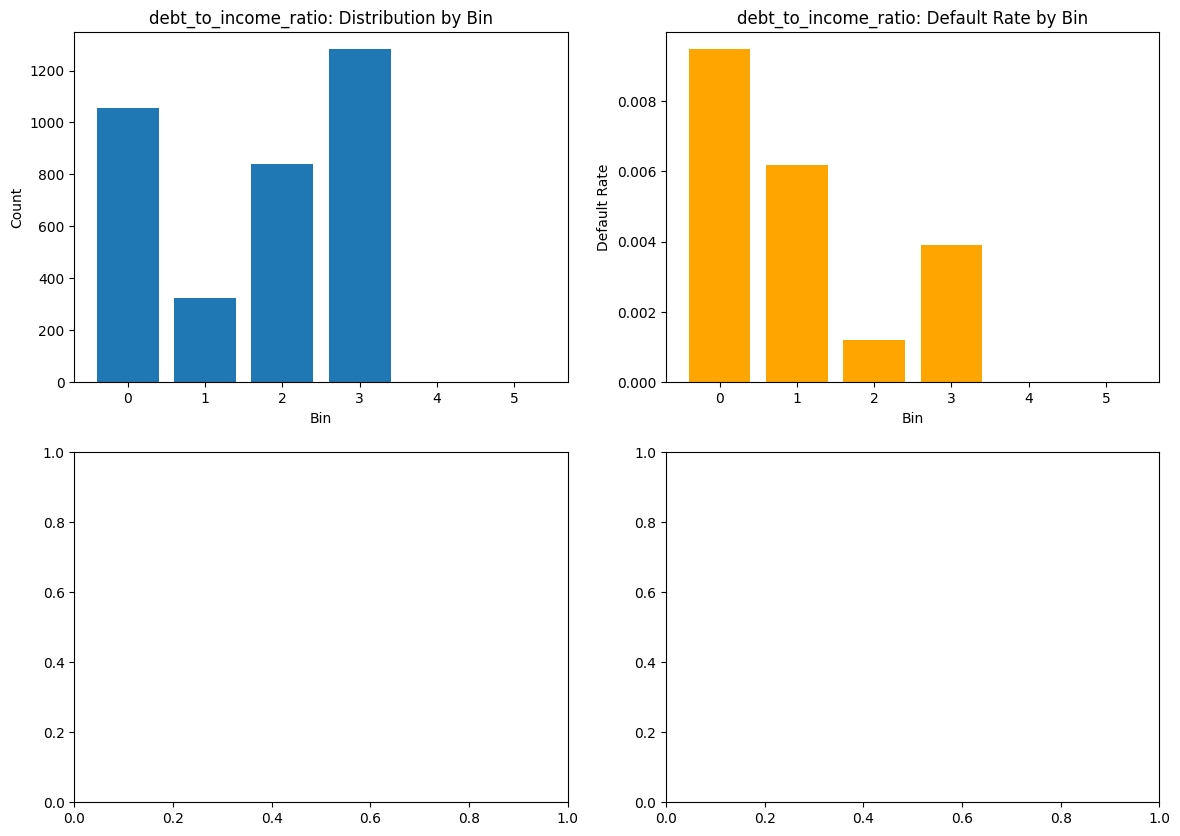

In [ ]:
# Create binning visualizer
from cr_score.binning import OptBinningWrapper

# Get one feature's binning
feature = 'debt_to_income_ratio'
binner = OptBinningWrapper(max_n_bins=5)
# Note: fit() takes a Series (not DataFrame) and target Series
binner.fit(train_df[feature], train_df['default'])

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get binning table (note: optbinning uses capitalized column names with spaces)
bin_table = binner.get_binning_table()

# Display the table structure
print("Binning table columns:", bin_table.columns.tolist())
print("\nBinning table:")
print(bin_table)

# Distribution (optbinning uses "Count" not "count")
ax = axes[0, 0]
ax.bar(range(len(bin_table)-1), bin_table['Count'][:-1])  # Exclude last row (totals)
ax.set_title(f'{feature}: Distribution by Bin')
ax.set_xlabel('Bin')
ax.set_ylabel('Count')

# Event Rate (optbinning uses "Event rate" not "event_rate")
ax = axes[0, 1]
ax.bar(range(len(bin_table)-1), bin_table['Event rate'][:-1], color='orange')
ax.set_title(f'{feature}: Default Rate by Bin')
ax.set_xlabel('Bin')
ax.set_ylabel('Default Rate')

# WoE (optbinning uses "WoE" not "woe")
ax = axes[1, 0]
ax.bar(range(len(bin_table)-1), bin_table['WoE'][:-1], color='green')
ax.set_title(f'{feature}: Weight of Evidence (WoE)')
ax.set_xlabel('Bin')
ax.set_ylabel('WoE')

# IV (optbinning uses "IV" not "iv")
ax = axes[1, 1]
# Note: IV is cumulative, use individual bin IV if available
ax.bar(range(len(bin_table)-1), bin_table['IV'][:-1], color='red')
ax.set_title(f'{feature}: Information Value (IV) by Bin')
ax.set_xlabel('Bin')
ax.set_ylabel('IV')

plt.tight_layout()
plt.show()

# Total IV is in the last row
print(f"Total IV for {feature}: {binner.get_iv():.3f}")

## Step 3: Scorecard Performance Plots

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(test_df['default'], probas)
auc = roc_auc_score(test_df['default'], probas)

ax = axes[0]
ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
ax.grid(alpha=0.3)

# Score Distribution
goods = scores[test_df['default'] == 0]
bads = scores[test_df['default'] == 1]

ax = axes[1]
ax.hist(goods, bins=30, alpha=0.6, label='Good', color='green')
ax.hist(bads, bins=30, alpha=0.6, label='Bad', color='red')
ax.set_xlabel('Credit Score')
ax.set_ylabel('Count')
ax.set_title('Score Distribution')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"[OK] Performance visualizations created!")

## Step 4: Generate HTML Report

In [ ]:
# Generate comprehensive report
report_gen = HTMLReportGenerator()

report_html = report_gen.generate(
    pipeline=pipeline,
    test_df=test_df,
    target_col='default',
    report_title="Credit Scorecard Report",
    author="Your Name"
)

# Save report
with open('scorecard_report.html', 'w', encoding='utf-8') as f:
    f.write(report_html)

print("[OK] HTML report generated: scorecard_report.html")
print("Open it in your browser to see the full report!")

## Summary

You learned how to:
- Visualize binning results (WoE, IV, distributions)
- Create performance plots (ROC, KS, calibration)
- Analyze score distributions
- Generate professional HTML reports

**Next:** Playbook 04 for the complete workflow!